In [1]:
import os, sys
import numpy as np
import tensorflow as tf
import neurite as ne
import voxelmorph as vxm
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from PIL import Image
%load_ext autoreload
%autoreload 2

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Load and Process Data

## Create data

In [3]:
def create_training_files(raw_data_path,new_data_path,seed=1):
    np.random.seed(seed)
    valid_files = [f for f in os.listdir(raw_data_path) if os.path.isfile(raw_data_path+"/"+f)]
    for i in range(len(valid_files)):
        image_dir = new_data_path+"/"+str(i)
        os.mkdir(image_dir)
        image = Image.open(raw_data_path+"/"+valid_files[i])
        new_image = reshape_image(image)
        new_image.save(image_dir+"/0.jpg")
        degree = np.random.randint(low=-6,high=6)
        image_rotated = new_image.rotate(degree)
        image_rotated.save(image_dir+"/1.jpg")

In [4]:
def reshape_image(image,shape=(512,442)):
    small_image = image.resize(shape,resample=Image.LANCZOS)
    new_image = Image.new(small_image.mode, (shape[0],shape[0]), (0,0,0))
    new_image.paste(small_image,(0,0))
    new_image = new_image.convert("L")
    return new_image

512,442 /// 128,111

In [9]:
create_training_files("/epfl/master/ML/ml-project-2/local_training/data/raw_ppm/",
                        "/EPFL/master/ML/ml-project-2/local_training/data/mixed")

## Load data 

In [2]:
def load_data(input_path):
    tot = len(os.listdir(input_path))
    data = np.zeros((tot,2,512,512),dtype=np.float32)
    for i in range(tot):
        fix = Image.open(input_path+"/"+str(i)+"/0.jpg")
        moved = Image.open(input_path+"/"+str(i)+"/1.jpg")
        data[i][0] = np.asarray(fix)[:,:]/255
        data[i][1] = np.asarray(moved)[:,:]/255
    return data

In [6]:
data = load_data("data/mixed")
train = data[:-47]
test = data[-47:]

---

# Model Initialisation

## Losses

In [7]:
# voxelmorph has a variety of custom loss classes
losses = [vxm.losses.MSE().loss, vxm.losses.Grad('l2').loss]

# usually, we have to balance the two losses by a hyper-parameter
lambda_param = 0.03
loss_weights = [1, lambda_param]

## Model

In [25]:
# build model using VxmDense
inshape = (512,512)
nb_features = [
    [16, 32, 32, 32],         # encoder features
    [32, 32, 32, 32, 32, 16, 16]  # decoder features
]
vxm_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)

<class 'keras.layers.convolutional.Conv2D'> 2 (None, 512, 512, 2)
(None, 512, 512, 2)
False 2 512


In [8]:
vxm_model.compile(optimizer='Adam', loss=losses, loss_weights=loss_weights)

---

# Training

## Data generator

In [9]:
def vxm_data_generator(data,batch_size=8):

    # preliminary sizing
    vol_shape = data.shape[2:] # extract data shape
    ndims = len(vol_shape)
    
    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    
    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx = np.random.randint(0, data.shape[0], size=batch_size)
        fixed_images = data[idx, 0, ..., np.newaxis]
        moving_images = data[idx, 1, ..., np.newaxis]
        inputs = [moving_images, fixed_images]
        
        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare 
        # the resulting moved image with the fixed image. 
        # we also wish to penalize the deformation field. 
        outputs = [fixed_images, zero_phi]
        
        yield (inputs, outputs)

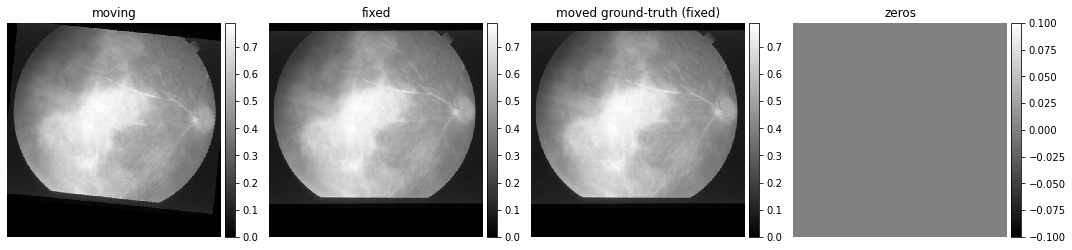

In [10]:
# let's test it
train_generator = vxm_data_generator(train)
in_sample, out_sample = next(train_generator)

# visualize
images = [img[0, :, :,0] for img in in_sample + out_sample] 
titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

## Training

In [11]:
nb_epochs = 500
steps_per_epoch = 48
hist = vxm_model.fit_generator(train_generator, epochs=nb_epochs, steps_per_epoch=steps_per_epoch, verbose=2);

<ipython-input-11-8b53c509950a>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = vxm_model.fit_generator(train_generator, epochs=nb_epochs, steps_per_epoch=steps_per_epoch, verbose=2);


Epoch 1/500
48/48 - 68s - loss: 0.0019 - transformer_loss: 0.0019 - flow_loss: 4.8903e-04 - 68s/epoch - 1s/step
Epoch 2/500
48/48 - 48s - loss: 0.0010 - transformer_loss: 9.4656e-04 - flow_loss: 0.0034 - 48s/epoch - 1s/step
Epoch 3/500
48/48 - 19s - loss: 9.3203e-04 - transformer_loss: 8.2138e-04 - flow_loss: 0.0037 - 19s/epoch - 401ms/step
Epoch 4/500
48/48 - 14s - loss: 9.1990e-04 - transformer_loss: 8.0420e-04 - flow_loss: 0.0039 - 14s/epoch - 294ms/step
Epoch 5/500
48/48 - 14s - loss: 8.3963e-04 - transformer_loss: 7.2761e-04 - flow_loss: 0.0037 - 14s/epoch - 294ms/step
Epoch 6/500
48/48 - 14s - loss: 7.7820e-04 - transformer_loss: 6.5997e-04 - flow_loss: 0.0039 - 14s/epoch - 294ms/step
Epoch 7/500
48/48 - 14s - loss: 7.0800e-04 - transformer_loss: 6.0000e-04 - flow_loss: 0.0036 - 14s/epoch - 294ms/step
Epoch 8/500
48/48 - 14s - loss: 6.9675e-04 - transformer_loss: 5.8076e-04 - flow_loss: 0.0039 - 14s/epoch - 297ms/step
Epoch 9/500
48/48 - 14s - loss: 7.3408e-04 - transformer_loss:

Epoch 70/500
48/48 - 14s - loss: 3.4398e-04 - transformer_loss: 2.3919e-04 - flow_loss: 0.0035 - 14s/epoch - 296ms/step
Epoch 71/500
48/48 - 14s - loss: 3.3656e-04 - transformer_loss: 2.3671e-04 - flow_loss: 0.0033 - 14s/epoch - 296ms/step
Epoch 72/500
48/48 - 14s - loss: 3.1571e-04 - transformer_loss: 2.2037e-04 - flow_loss: 0.0032 - 14s/epoch - 296ms/step
Epoch 73/500
48/48 - 14s - loss: 3.3221e-04 - transformer_loss: 2.3444e-04 - flow_loss: 0.0033 - 14s/epoch - 296ms/step
Epoch 74/500
48/48 - 14s - loss: 3.3496e-04 - transformer_loss: 2.3556e-04 - flow_loss: 0.0033 - 14s/epoch - 297ms/step
Epoch 75/500
48/48 - 14s - loss: 2.9305e-04 - transformer_loss: 2.0177e-04 - flow_loss: 0.0030 - 14s/epoch - 297ms/step
Epoch 76/500
48/48 - 14s - loss: 3.0107e-04 - transformer_loss: 2.0931e-04 - flow_loss: 0.0031 - 14s/epoch - 296ms/step
Epoch 77/500
48/48 - 14s - loss: 3.3646e-04 - transformer_loss: 2.3684e-04 - flow_loss: 0.0033 - 14s/epoch - 296ms/step
Epoch 78/500
48/48 - 14s - loss: 3.1058e

Epoch 138/500
48/48 - 15s - loss: 2.9524e-04 - transformer_loss: 2.0140e-04 - flow_loss: 0.0031 - 15s/epoch - 316ms/step
Epoch 139/500
48/48 - 14s - loss: 2.5648e-04 - transformer_loss: 1.6851e-04 - flow_loss: 0.0029 - 14s/epoch - 293ms/step
Epoch 140/500
48/48 - 14s - loss: 2.4763e-04 - transformer_loss: 1.6428e-04 - flow_loss: 0.0028 - 14s/epoch - 294ms/step
Epoch 141/500
48/48 - 14s - loss: 2.8245e-04 - transformer_loss: 1.9610e-04 - flow_loss: 0.0029 - 14s/epoch - 295ms/step
Epoch 142/500
48/48 - 14s - loss: 2.5611e-04 - transformer_loss: 1.7087e-04 - flow_loss: 0.0028 - 14s/epoch - 295ms/step
Epoch 143/500
48/48 - 14s - loss: 2.3096e-04 - transformer_loss: 1.5051e-04 - flow_loss: 0.0027 - 14s/epoch - 296ms/step
Epoch 144/500
48/48 - 14s - loss: 2.4643e-04 - transformer_loss: 1.6061e-04 - flow_loss: 0.0029 - 14s/epoch - 296ms/step
Epoch 145/500
48/48 - 14s - loss: 2.9106e-04 - transformer_loss: 2.0254e-04 - flow_loss: 0.0030 - 14s/epoch - 298ms/step
Epoch 146/500
48/48 - 14s - loss

Epoch 206/500
48/48 - 14s - loss: 2.1550e-04 - transformer_loss: 1.3768e-04 - flow_loss: 0.0026 - 14s/epoch - 297ms/step
Epoch 207/500
48/48 - 14s - loss: 2.2132e-04 - transformer_loss: 1.4517e-04 - flow_loss: 0.0025 - 14s/epoch - 297ms/step
Epoch 208/500
48/48 - 14s - loss: 2.3890e-04 - transformer_loss: 1.5907e-04 - flow_loss: 0.0027 - 14s/epoch - 297ms/step
Epoch 209/500
48/48 - 14s - loss: 2.3452e-04 - transformer_loss: 1.5224e-04 - flow_loss: 0.0027 - 14s/epoch - 297ms/step
Epoch 210/500
48/48 - 14s - loss: 2.7213e-04 - transformer_loss: 1.8476e-04 - flow_loss: 0.0029 - 14s/epoch - 297ms/step
Epoch 211/500
48/48 - 14s - loss: 2.4366e-04 - transformer_loss: 1.5888e-04 - flow_loss: 0.0028 - 14s/epoch - 297ms/step
Epoch 212/500
48/48 - 14s - loss: 2.1992e-04 - transformer_loss: 1.4401e-04 - flow_loss: 0.0025 - 14s/epoch - 298ms/step
Epoch 213/500
48/48 - 14s - loss: 2.4944e-04 - transformer_loss: 1.6238e-04 - flow_loss: 0.0029 - 14s/epoch - 297ms/step
Epoch 214/500
48/48 - 14s - loss

Epoch 274/500
48/48 - 14s - loss: 1.9510e-04 - transformer_loss: 1.2380e-04 - flow_loss: 0.0024 - 14s/epoch - 296ms/step
Epoch 275/500
48/48 - 14s - loss: 2.1383e-04 - transformer_loss: 1.3967e-04 - flow_loss: 0.0025 - 14s/epoch - 296ms/step
Epoch 276/500
48/48 - 14s - loss: 2.2234e-04 - transformer_loss: 1.4483e-04 - flow_loss: 0.0026 - 14s/epoch - 297ms/step
Epoch 277/500
48/48 - 14s - loss: 2.3406e-04 - transformer_loss: 1.5319e-04 - flow_loss: 0.0027 - 14s/epoch - 297ms/step
Epoch 278/500
48/48 - 14s - loss: 2.3289e-04 - transformer_loss: 1.5242e-04 - flow_loss: 0.0027 - 14s/epoch - 297ms/step
Epoch 279/500
48/48 - 14s - loss: 2.1203e-04 - transformer_loss: 1.3683e-04 - flow_loss: 0.0025 - 14s/epoch - 297ms/step
Epoch 280/500
48/48 - 14s - loss: 1.9232e-04 - transformer_loss: 1.2180e-04 - flow_loss: 0.0024 - 14s/epoch - 297ms/step
Epoch 281/500
48/48 - 14s - loss: 1.9016e-04 - transformer_loss: 1.1992e-04 - flow_loss: 0.0023 - 14s/epoch - 297ms/step
Epoch 282/500
48/48 - 14s - loss

Epoch 342/500
48/48 - 14s - loss: 1.8837e-04 - transformer_loss: 1.1985e-04 - flow_loss: 0.0023 - 14s/epoch - 299ms/step
Epoch 343/500
48/48 - 14s - loss: 1.8320e-04 - transformer_loss: 1.1195e-04 - flow_loss: 0.0024 - 14s/epoch - 297ms/step
Epoch 344/500
48/48 - 14s - loss: 1.8375e-04 - transformer_loss: 1.1469e-04 - flow_loss: 0.0023 - 14s/epoch - 297ms/step
Epoch 345/500
48/48 - 15s - loss: 2.2314e-04 - transformer_loss: 1.4277e-04 - flow_loss: 0.0027 - 15s/epoch - 303ms/step
Epoch 346/500
48/48 - 15s - loss: 1.8398e-04 - transformer_loss: 1.1724e-04 - flow_loss: 0.0022 - 15s/epoch - 302ms/step
Epoch 347/500
48/48 - 15s - loss: 2.5063e-04 - transformer_loss: 1.6572e-04 - flow_loss: 0.0028 - 15s/epoch - 305ms/step
Epoch 348/500
48/48 - 17s - loss: 2.2674e-04 - transformer_loss: 1.5162e-04 - flow_loss: 0.0025 - 17s/epoch - 345ms/step
Epoch 349/500
48/48 - 15s - loss: 2.4105e-04 - transformer_loss: 1.6006e-04 - flow_loss: 0.0027 - 15s/epoch - 304ms/step
Epoch 350/500
48/48 - 44s - loss

Epoch 410/500
48/48 - 14s - loss: 1.8917e-04 - transformer_loss: 1.1915e-04 - flow_loss: 0.0023 - 14s/epoch - 297ms/step
Epoch 411/500
48/48 - 14s - loss: 2.0587e-04 - transformer_loss: 1.3104e-04 - flow_loss: 0.0025 - 14s/epoch - 298ms/step
Epoch 412/500
48/48 - 14s - loss: 2.0112e-04 - transformer_loss: 1.2778e-04 - flow_loss: 0.0024 - 14s/epoch - 297ms/step
Epoch 413/500
48/48 - 14s - loss: 2.2355e-04 - transformer_loss: 1.4404e-04 - flow_loss: 0.0027 - 14s/epoch - 297ms/step
Epoch 414/500
48/48 - 14s - loss: 2.2255e-04 - transformer_loss: 1.4356e-04 - flow_loss: 0.0026 - 14s/epoch - 297ms/step
Epoch 415/500
48/48 - 14s - loss: 1.9411e-04 - transformer_loss: 1.2126e-04 - flow_loss: 0.0024 - 14s/epoch - 297ms/step
Epoch 416/500
48/48 - 14s - loss: 2.1419e-04 - transformer_loss: 1.3637e-04 - flow_loss: 0.0026 - 14s/epoch - 297ms/step
Epoch 417/500
48/48 - 14s - loss: 1.9564e-04 - transformer_loss: 1.2445e-04 - flow_loss: 0.0024 - 14s/epoch - 297ms/step
Epoch 418/500
48/48 - 14s - loss

Epoch 478/500
48/48 - 14s - loss: 1.9243e-04 - transformer_loss: 1.1991e-04 - flow_loss: 0.0024 - 14s/epoch - 299ms/step
Epoch 479/500
48/48 - 14s - loss: 1.7903e-04 - transformer_loss: 1.1103e-04 - flow_loss: 0.0023 - 14s/epoch - 297ms/step
Epoch 480/500
48/48 - 14s - loss: 1.7648e-04 - transformer_loss: 1.0916e-04 - flow_loss: 0.0022 - 14s/epoch - 297ms/step
Epoch 481/500
48/48 - 14s - loss: 1.9019e-04 - transformer_loss: 1.1826e-04 - flow_loss: 0.0024 - 14s/epoch - 297ms/step
Epoch 482/500
48/48 - 14s - loss: 2.1316e-04 - transformer_loss: 1.4110e-04 - flow_loss: 0.0024 - 14s/epoch - 297ms/step
Epoch 483/500
48/48 - 14s - loss: 2.1217e-04 - transformer_loss: 1.3588e-04 - flow_loss: 0.0025 - 14s/epoch - 297ms/step
Epoch 484/500
48/48 - 14s - loss: 1.8374e-04 - transformer_loss: 1.1588e-04 - flow_loss: 0.0023 - 14s/epoch - 297ms/step
Epoch 485/500
48/48 - 14s - loss: 1.9744e-04 - transformer_loss: 1.2670e-04 - flow_loss: 0.0024 - 14s/epoch - 297ms/step
Epoch 486/500
48/48 - 14s - loss

---

# Results

In [46]:
vxm_model.save_weights("/EPFL/master/ML/ml-project-2/local_training/results/model/3h/weights/wi/try")

In [20]:
def save_results(images,path,name):
    if not os.path.isdir(path):
        os.mkdir(path)
    plt.imsave(path+"/"+name+"_"+str(0)+".png", images[1], cmap="gray")
    plt.imsave(path+"/"+name+"_"+str(1)+".png", images[0], cmap="gray")
    plt.imsave(path+"/"+name+"_"+str(2)+".png", images[2], cmap="gray")

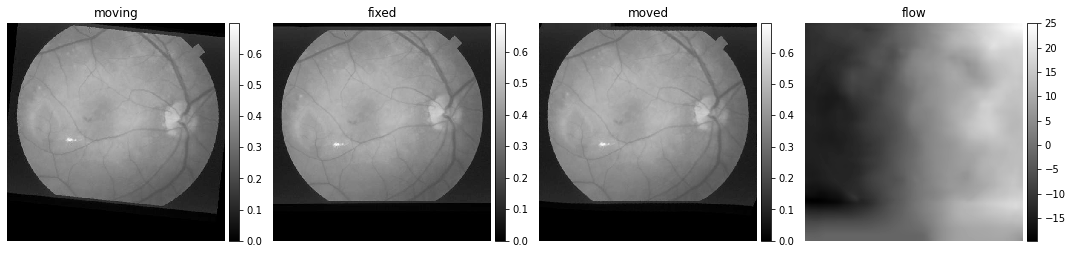

In [33]:
# let's get some data
val_generator = vxm_data_generator(test, batch_size = 1)
val_input, _ = next(val_generator)
val_pred = vxm_model.predict(val_input)

# visualize
images = [img[0, :, :, 0] for img in val_input + val_pred] 
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

In [34]:
save_results(images,"/epfl/master/ml/ml-project-2/local_training/results/8","3")

In [36]:
ne.plot.flow([val_pred[1][0,:,:,:].squeeze()], width=20);

---

# Load Model

In [39]:
# build model using VxmDense
inshape = (512,512)
nb_features = [
    [16, 32, 32, 32],         # encoder features
    [32, 32, 32, 32, 32, 16, 16]  # decoder features
]
new_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)

In [41]:
new_model.load_weights("/EPFL/master/ML/ml-project-2/local_training/results/model/3h/weights");

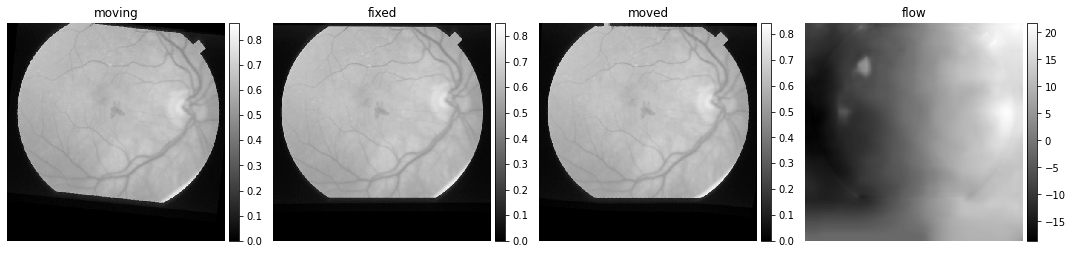

In [44]:
# let's get some data
val_generator = vxm_data_generator(test, batch_size = 1)
val_input, _ = next(val_generator)
val_pred = new_model.predict(val_input)

# visualize
images = [img[0, :, :, 0] for img in val_input + val_pred] 
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

In [45]:
save_results(images,"/epfl/master/ml/ml-project-2/local_training/results/8","4")